# Computational Statistics - Project
## Authors : Aurélie Wasem & Marcelo Tavares

In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
train_df = pd.read_csv('data/train.csv')

In [4]:
lst = ['SalePrice', 'GrLivArea', 'LotArea', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'GarageArea', '1stFlrSF',
       '2ndFlrSF', 'FullBath', 'HalfBath', 'BedroomAbvGr',  
       'TotRmsAbvGrd', 'WoodDeckSF', 'ScreenPorch', 'PoolArea']

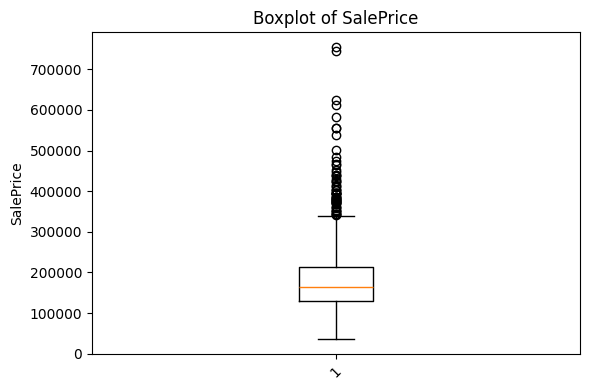

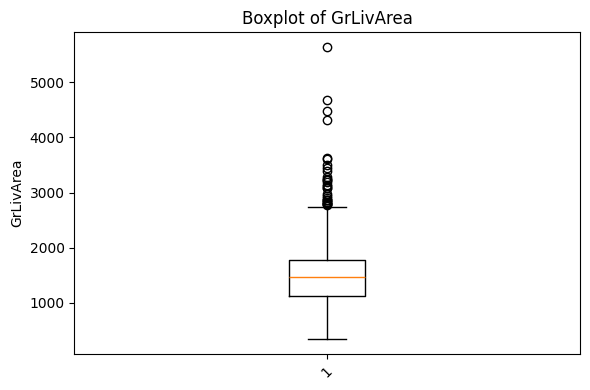

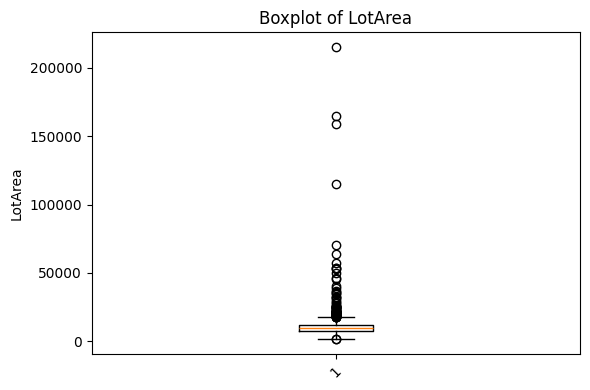

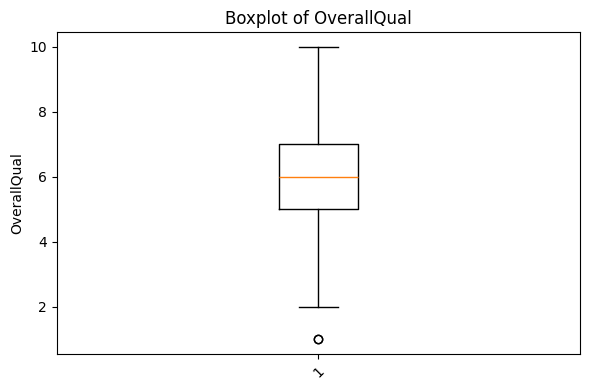

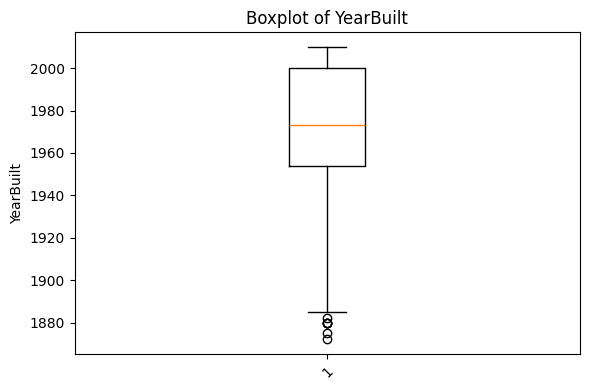

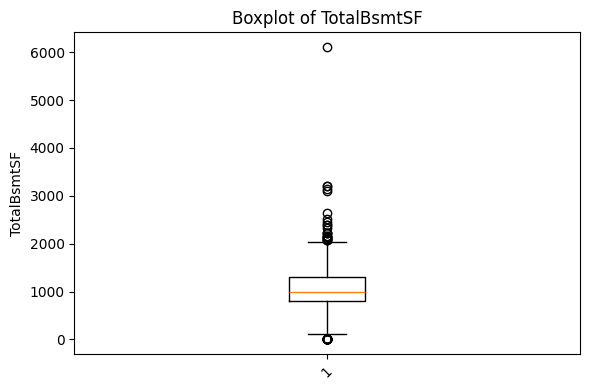

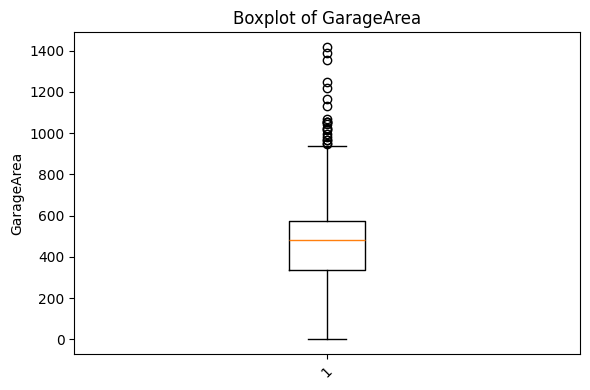

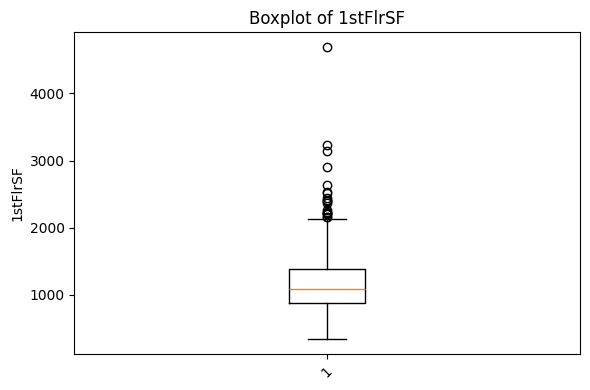

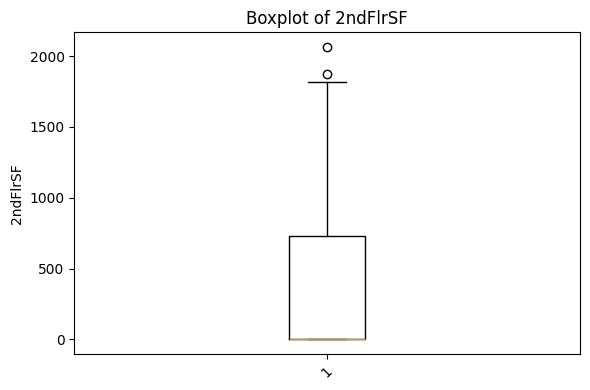

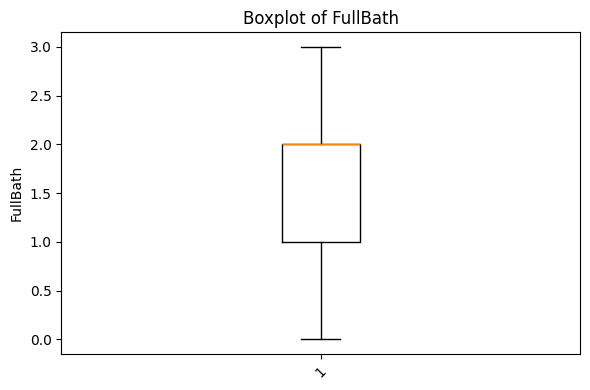

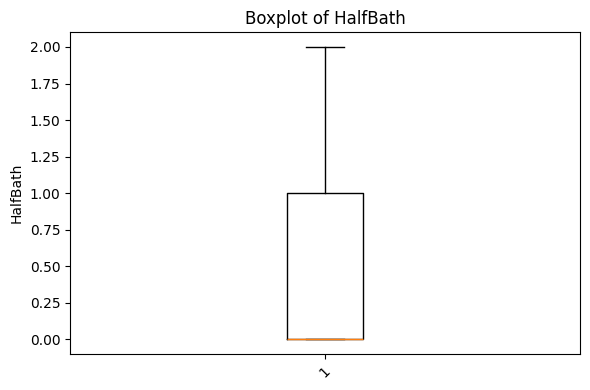

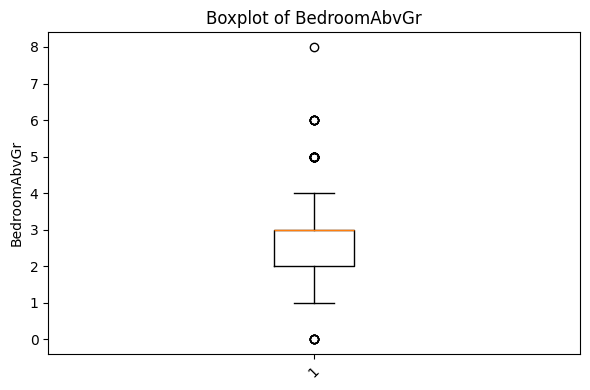

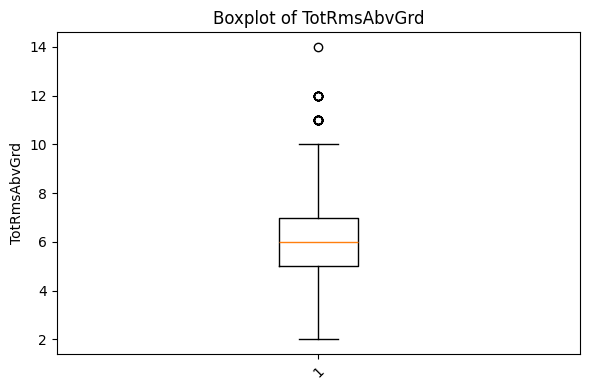

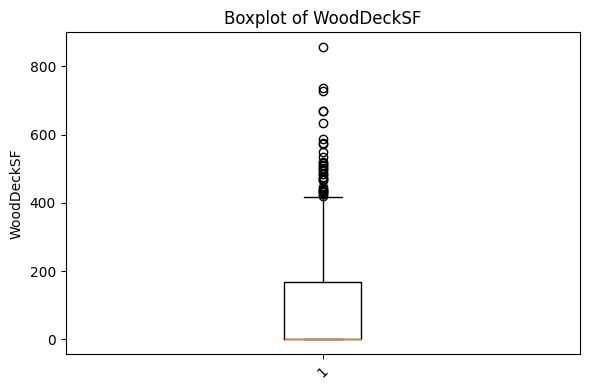

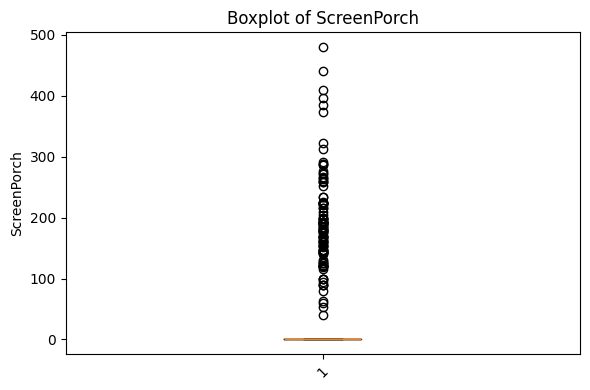

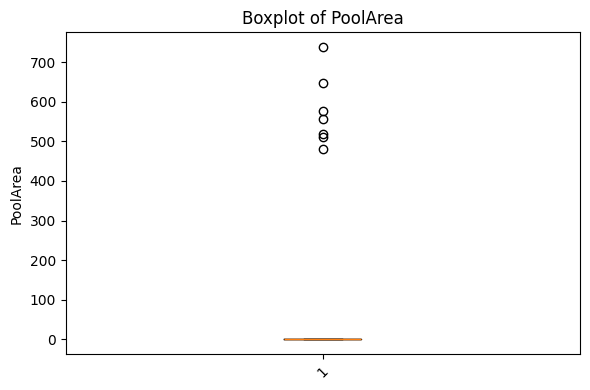

In [8]:
# Parcourir toutes les colonnes
for column in lst:
    plt.figure(figsize=(6, 4))
    if train_df[column].dtype in ['int64', 'float64']:
        # Boxplot classique pour les colonnes numériques
        plt.boxplot(train_df[column].dropna())
        plt.title(f'Boxplot of {column}')
        plt.ylabel(column)
    else:
        # Boxplot SalePrice par modalité pour les colonnes qualitatives
        if 'SalePrice' in train_df.columns:
            try:
                train_df.boxplot(column='SalePrice', by=column, grid=False, figsize=(8, 5))
                plt.title(f'SalePrice by {column}')
                plt.suptitle('')
                plt.ylabel("SalePrice")
            except:
                plt.close()  # Certaines colonnes peuvent poser problème si trop de catégories uniques

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [9]:
# Fonction pour détecter les outliers via la méthode IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Stocker les seuils pour chaque variable
outlier_bounds = []
outlier_filtered_df = train_df.copy()

for var in lst:
    if var == 'PoolArea' or var == 'ScreenPorch':
        continue
    series = train_df[var].dropna()
    lower, upper = detect_outliers_iqr(series)

    # Enregistrer les bornes
    outlier_bounds.append({
        'Variable': var,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'Nb Outliers (low)': (series < lower).sum(),
        'Nb Outliers (high)': (series > upper).sum()
    })

    # Supprimer les outliers dans une copie du DataFrame
    outlier_filtered_df = outlier_filtered_df[(outlier_filtered_df[var] >= lower) & (outlier_filtered_df[var] <= upper)]

# Résumé sous forme de tableau
outlier_bounds_df = pd.DataFrame(outlier_bounds)

# Afficher les seuils pour l'utilisateur
#import ace_tools as tools; tools.display_dataframe_to_user(name="Outlier Thresholds (IQR Method)", dataframe=outlier_bounds_df)

# Enregistrer le DataFrame filtré sans outliers pour usage futur
filtered_df = outlier_filtered_df.copy().filter(lst)
filtered_df

,SalePrice,GrLivArea,LotArea,OverallQual,YearBuilt,TotalBsmtSF,GarageArea,1stFlrSF,2ndFlrSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,WoodDeckSF,ScreenPorch,PoolArea
0,208500,1710,8450,7,2003,856,548,856,854,2,1,3,8,0,0,0
1,181500,1262,9600,6,1976,1262,460,1262,0,2,0,3,6,298,0,0
2,223500,1786,11250,7,2001,920,608,920,866,2,1,3,6,0,0,0
3,140000,1717,9550,7,1915,756,642,961,756,1,0,3,7,0,0,0
4,250000,2198,14260,8,2000,1145,836,1145,1053,2,1,4,9,192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,185000,1221,7500,7,2004,1221,400,1221,0,2,0,2,6,0,0,0
1455,175000,1647,7917,6,1999,953,460,953,694,2,1,3,7,0,0,0
1456,210000,2073,13175,6,1978,1542,500,2073,0,2,0,3,7,349,0,0
1457,266500,2340,9042,7,1941,1152,252,1188,1152,2,0,4,9,0,0,0


In [11]:
import statsmodels.api as sm

# Variables pour la régression linéaire
X = filtered_df.drop(columns='SalePrice')
y = filtered_df['SalePrice']

# Ajouter la constante (intercept) au modèle
X = sm.add_constant(X)

# Construire et ajuster le modèle
model = sm.OLS(y, X).fit()

# Résumé du modèle
regression_summary = model.summary()
regression_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     453.3
Date:                Fri, 02 May 2025   Prob (F-statistic):               0.00
Time:                        10:15:03   Log-Likelihood:                -13934.
No. Observations:                1220   AIC:                         2.790e+04
Df Residuals:                    1204   BIC:                         2.798e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.639e+05   6.78e+04    -11.260      0.000   -8.97e+05   -6.31e+05
GrLivArea       26.0333     16.996      1.532      0.126      -7.312      59.378
LotArea          2.2576      0.239      9.437      0.000       1.788       2.727
OverallQual   1.468e+04    814.578     18.021      0.000    1.31e+04    1.63e+04
YearBuilt      368.0728     35.615     10.335      0.000     298.198     437.947
TotalBsmtSF     33.0943      4.645      7.125      0.000      23.981      42.207
GarageArea      29.3470      4.312      6.805      0.000      20.887      37.807
1stFlrSF        23.0444     17.304      1.332      0.183     -10.905      56.994
2ndFlrSF        30.7558     16.856      1.825      0.068      -2.315      63.826
FullBath     -2326.1055   1985.900     -1.171      0.242   -6222.314    1570.103
HalfBath      -262.5049   1946.042     -0.135      0.893   -4080.515    3555.505
BedroomAbvGr -7112.8049   1321.081     -5.384      0.000   -9704.681   -4520.929
TotRmsAbvGrd  -141.0145    911.662     -0.155      0.877   -1929.636    1647.608
WoodDeckSF      32.9227      6.414      5.133      0.000      20.338      45.507
ScreenPorch     44.2276     12.364      3.577      0.000      19.970      68.485
PoolArea        18.9296     25.793      0.734      0.463     -31.674      69.533
==============================================================================
Omnibus:                       82.628   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.844
Skew:                          -0.119   Prob(JB):                     3.96e-77
Kurtosis:                       5.620   Cond. No.                     1.06e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# Préparation d'une liste pour stocker les résultats
results = []

# Pour chaque variable
for var in lst:
    data = filtered_df[var].dropna()  # On enlève les valeurs manquantes
    mean = data.mean()
    variance = data.var()
    n = len(data)
    std_err = stats.sem(data)
    
    # Intervalle de confiance à 95%
    ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean, scale=std_err)
    
    # Test d'hypothèse: H0 : mean = median
    median = np.median(data)
    t_stat, p_value = stats.ttest_1samp(data, median)
    
    results.append({
        'Variable': var,
        'Mean': mean,
        'Variance': variance,
        'CI 95% Lower': ci_low,
        'CI 95% Upper': ci_high,
        'T-statistic (mean=median)': t_stat,
        'P-value': p_value
    })

# Résultats dans un DataFrame
results_df = pd.DataFrame(results)
results_df['Significatif ?'] = results_df['P-value'].apply(lambda p: 'Oui' if p < 0.05 else 'Non')
results_df

,Variable,Mean,Variance,CI 95% Lower,CI 95% Upper,T-statistic (mean=median),P-value,Significatif ?
0,SalePrice,168646.697541,3.241143e+09,165448.916812,171844.478270,6.531994,9.508190e-11,Oui
1,GrLivArea,1418.675410,1.664569e+05,1395.758794,1441.592026,2.155289,3.133449e-02,Oui
2,LotArea,9036.103279,9.887858e+06,8859.478874,9212.727684,-0.826385,4.087473e-01,Non
3,OverallQual,6.016393,1.510806e+00,5.947353,6.085434,0.465850,6.414063e-01,Non
4,YearBuilt,1971.732787,8.620828e+02,1970.083584,1973.381990,-1.507492,1.319436e-01,Non
5,TotalBsmtSF,1025.039344,1.048470e+05,1006.851653,1043.227036,6.044982,1.983253e-09,Oui
6,GarageArea,451.470492,3.695769e+04,440.672275,462.268708,-1.913091,5.597051e-02,Non
7,1stFlrSF,1098.304918,9.851706e+04,1080.674796,1115.935040,5.653663,1.954631e-08,Oui
8,2ndFlrSF,316.531148,1.599592e+05,294.066264,338.996031,27.643421,5.562192e-131,Oui
9,FullBath,1.516393,2.696244e-01,1.487227,1.545560,-32.530633,1.268254e-167,Oui


In [20]:
# DataFrame pour stocker les résultats
regression_results = []

# Pour chaque variable (sauf SalePrice), on fait une régression simple
for var in lst:
    if var == 'SalePrice':
        continue
    mean = data.mean()
    variance = data.var()
    # Préparation des données
    X = filtered_df[[var]].dropna()
    y = filtered_df.loc[X.index, 'SalePrice']
    
    # Régression linéaire avec sklearn
    model = LinearRegression().fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_
    
    # Prédictions et erreur standard du coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    n = len(y)
    X_mean = np.mean(X[var])
    s_squared = np.sum((residuals)**2) / (n - 2)
    se_beta = np.sqrt(s_squared / np.sum((X[var] - X_mean)**2))
    
    # Statistiques du test d'hypothèse H0: beta ≠ 0 (impact significatif)
    t_stat = coef / se_beta
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=n - 2))
    
    # Intervalle de confiance à 95% du coefficient
    ci_low = coef - stats.t.ppf(0.975, df=n - 2) * se_beta
    ci_high = coef + stats.t.ppf(0.975, df=n - 2) * se_beta
    
    regression_results.append({
        'Variable': var,
        'Mean': mean,
        'Variance': variance,
        'Coefficient': coef,
        'CI 95% Lower': ci_low,
        'CI 95% Upper': ci_high,
        'T-statistic (H0: impact)': t_stat,
        'P-value': p_value,
        'Significatif ?': 'Oui' if p_value < 0.05 else 'Non'
    })

regression_df = pd.DataFrame(regression_results)

regression_df

,Variable,Mean,Variance,Coefficient,CI 95% Lower,CI 95% Upper,T-statistic (H0: impact),P-value,Significatif ?
0,GrLivArea,1.003279,615.629194,100.516256,95.075288,105.957223,36.244329,0.000000e+00,Oui
1,LotArea,1.003279,615.629194,6.953758,6.014041,7.893475,14.517856,0.000000e+00,Oui
2,OverallQual,1.003279,615.629194,36925.585667,35353.752483,38497.418851,46.089374,0.000000e+00,Oui
3,YearBuilt,1.003279,615.629194,1199.089362,1113.430300,1284.748425,27.463640,0.000000e+00,Oui
4,TotalBsmtSF,1.003279,615.629194,103.556697,95.569130,111.544265,25.435690,0.000000e+00,Oui
5,GarageArea,1.003279,615.629194,186.481661,173.549242,199.414079,28.290215,0.000000e+00,Oui
6,1stFlrSF,1.003279,615.629194,103.955393,95.599759,112.311028,24.408857,0.000000e+00,Oui
7,2ndFlrSF,1.003279,615.629194,41.776550,34.126893,49.426206,10.714466,0.000000e+00,Oui
8,FullBath,1.003279,615.629194,67169.514714,62298.119110,72040.910318,27.051957,0.000000e+00,Oui
9,HalfBath,1.003279,615.629194,30316.690910,24109.113351,36524.268468,9.581633,0.000000e+00,Oui


In [33]:
# Création d'une copie du DataFrame avec des noms compatibles pour la formule
df_formula = filtered_df.copy()

# Renommer les colonnes problématiques
df_formula = df_formula.rename(columns={
    '1stFlrSF': 'FirstFlrSF',
    '2ndFlrSF': 'SecondFlrSF'
})

# Mettre à jour la liste des variables avec les nouveaux noms
quant_vars_formula = [var if var not in ['1stFlrSF', '2ndFlrSF'] else
                      'FirstFlrSF' if var == '1stFlrSF' else 'SecondFlrSF'
                      for var in quant_vars]

# Construire la formule pour la régression multiple
formula = 'SalePrice ~ ' + ' + '.join(quant_vars_formula)

# Ajuster le modèle
multi_model = smf.ols(formula=formula, data=df_formula).fit()

# Table ANOVA
anova_table = sm.stats.anova_lm(multi_model, typ=2).reset_index().rename(columns={
    'index': 'Variable',
    'sum_sq': 'SS',
    'df': 'DF',
    'F': 'F',
    'PR(>F)': 'p_value'
})

# Ajouter colonne MS (Mean Square = SS / DF)
anova_table['MS'] = anova_table['SS'] / anova_table['DF']

# Ajouter colonne "Significatif ?"
anova_table['Significatif ?'] = anova_table['p_value'].apply(
    lambda p: 'NaN' if pd.isna(p) else ('Oui' if p < 0.05 else 'Non')
)
# Réorganiser les colonnes
anova_table = anova_table[['Variable', 'SS', 'DF', 'MS', 'F', 'p_value', 'Significatif ?']]

# Calcul de la somme des carrés totale (SS total) et DF total
ss_total = anova_table['SS'].sum()
df_total = anova_table['DF'].sum()

# Calcul de MS total (facultatif, ici on peut mettre NaN car ça n'a pas de signification directe)
ms_total = np.nan

# Ajout de la ligne 'Total' à la table ANOVA
anova_total_row= pd.DataFrame([{
    'Variable': 'Total',
    'SS': ss_total,
    'DF': df_total,
    'MS': ms_total,
    'F': np.nan,
    'p_value': np.nan,
    'Significatif ?': ''
}])

anova_table = pd.concat([anova_table, anova_total_row], ignore_index=True)


anova_table

,Variable,SS,DF,MS,F,p_value,Significatif ?
0,GrLivArea,1.158159e+09,1.0,1.158159e+09,2.346206,1.258510e-01,Non
1,LotArea,4.396293e+10,1.0,4.396293e+10,89.060404,1.907147e-20,Oui
2,OverallQual,1.603047e+11,1.0,1.603047e+11,324.746386,1.835758e-64,Oui
3,YearBuilt,5.272335e+10,1.0,5.272335e+10,106.807330,4.794987e-24,Oui
4,TotalBsmtSF,2.505955e+10,1.0,2.505955e+10,50.765808,1.787678e-12,Oui
5,GarageArea,2.286233e+10,1.0,2.286233e+10,46.314672,1.584136e-11,Oui
6,FirstFlrSF,8.754642e+08,1.0,8.754642e+08,1.773521,1.831989e-01,Non
7,SecondFlrSF,1.643404e+09,1.0,1.643404e+09,3.329218,6.830693e-02,Non
8,FullBath,6.772455e+08,1.0,6.772455e+08,1.371969,2.417057e-01,Non
9,HalfBath,8.981986e+06,1.0,8.981986e+06,0.018196,8.927201e-01,Non
